# Comparison of Analysis1 and Analysis2
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.3.0
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset

Analysis1 = "/home/pissmaster/Desktop/dataset2 (Copy)/ci_brain_dec2023_counts_brain.txt"  
df1 = pd.read_csv(Analysis1, sep="\t")
df1
df2 =pd.read_csv('/home/pissmaster/Desktop/botryllus brain analysis2/Brain_scRNA_Dec_2023_BRAIN_Counts_Table.csv')
df2

,GI,Gene_Name,Gene_Note,Aligned_PAC4_Plate3_O06_ILW105_Brain_AB_Zooid_small_3_p09c11r08_6941c_13_19_months_S863.out.counts.txt,Aligned_PAC4_Plate3_M02_ILW104_Brain_AB_Zooid_small_2_p09c05r03_6941c_13_19_months_S797.out.counts.txt,Aligned_PAC4_Plate2_M16_ILW103_Brain_AB_Zooid_large_3_p07c01r06_6941c_13_19_months_S637.out.counts.txt,Aligned_PAC4_Plate2_K15_ILW102_Brain_B2_Zooid_large_2_p07c07r04_6941c_13_19_months_S619.out.counts.txt,Aligned_PAC4_Plate3_G11_ILW106_Brain_AB_Zooid_large_4_p10c11r06_6941c_13_19_months_S935.out.counts.txt,Aligned_PAC4_Plate2_O09_ILW101_Brain_B2_Zooid_large_1_p06c11r04_6941c_1_19_months_S527.out.counts.txt,Aligned_PAC4_Plate3_G08_ILW105_Brain_AB_Zooid_small_3_p10c11r02_6941c_13_19_months_S887.out.counts.txt,...,Aligned_PAC4_Plate2_L11_ILW102_Brain_B2_Zooid_large_2_p06c04r07_6941c_1_19_months_S556.out.counts.txt,Aligned_PAC4_Plate3_B12_ILW106_Brain_AB_Zooid_large_4_p10c10r07_6941c_13_19_months_S946.out.counts.txt,Aligned_PAC4_Plate2_I23_ILW104_Brain_AB_Zooid_small_2_p08c01r07_6941c_13_19_months_S745.out.counts.txt,Aligned_PAC4_Plate2_N07_ILW101_Brain_B2_Zooid_large_1_p06c02r02_6941c_1_19_months_S494.out.counts.txt,Aligned_PAC4_Plate2_L18_ILW103_Brain_AB_Zooid_large_3_p07c08r08_6941c_13_19_months_S668.out.counts.txt,Aligned_PAC4_Plate2_O07_ILW101_Brain_B2_Zooid_large_1_p06c03r02_6941c_1_19_months_S495.out.counts.txt,Aligned_PAC4_Plate2_P04_ILW100_Brain_B2_Zooid_small_1_p05c04r06_6941c_1_19_months_S448.out.counts.txt,Aligned_PAC4_Plate3_N12_ILW106_Brain_AB_Zooid_large_4_p10c10r08_6941c_13_19_months_S958.out.counts.txt,Aligned_PAC4_Plate2_F22_ILW103_Brain_AB_Zooid_large_3_p08c06r05_6941c_13_19_months_S726.out.counts.txt,Aligned_PAC4_Plate3_G14_ILW106_Brain_AB_Zooid_large_4_p11c11r02_6941c_13_19_months_S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72113,__no_feature,NaN,NaN,62,236947,169288,255,350440,2982,35889,...,18741,7537,1104,387400,87939,392462,15597,4041,21610,105402
72114,__ambiguous,NaN,NaN,0,2162,1735,0,3524,16,189,...,110,52,3,1987,795,1812,79,17,199,904
72115,__too_low_aQual,NaN,NaN,0,18,33,0,47,0,1,...,2,2,0,35,14,43,2,0,3,4
72116,__not_aligned,NaN,NaN,17873,330876,256172,48483,586055,9333,292376,...,26679,51094,12786,822342,136587,909838,36070,99680,272789,271757


In [5]:
#print shape df1 and df2
print("Shape of df1:", df1.shape)
print("Shape of df2:", df2.shape)

Shape of df1: (44732, 685)
Shape of df2: (72118, 686)


# Pre_Processing

In [6]:
# df1
#================================================
# Identify metadata columns (first three columns)
main_columns = [col for col in df1.columns if col not in ["V1", "V2"]]

new_column_names = []
for col in main_columns:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[3]  # ILWXYZ (Sample ID)
        region = parts[5]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if parts[12].isdigit() and parts[13] == "months":
            age = f"{parts[12]}_{parts[13]}"  # "19_months"
            replicate = parts[9]  # Replicate (pXXcXXrXX)
            sample_number = parts[14]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-4] if len(parts) > 4 else "Unknown"
            sample_number = parts[-3] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# Rename columns in DataFrame
df1.columns = ["Gene_ID", "Gene_Name"] + new_column_names
display(df1.head())
#================================================
# df2
#================================================
# Identify metadata columns (first three columns)
metadata_cols = df2.columns[:3]
sample_cols = df2.columns[3:]

new_column_names = []
for col in sample_cols:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[4]  # ILWXYZ (Sample ID)
        region = parts[6]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if len(parts) > 14 and parts[13].isdigit() and parts[14] == "months":
            age = f"{parts[13]}_{parts[14]}"  # "19_months"
            replicate = parts[10]  # Replicate (pXXcXXrXX)
            sample_number = parts[15]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-3] if len(parts) > 4 else "Unknown"
            sample_number = parts[-2] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# # rename g_unique column name to Gene_ID
# df.rename(columns={'g_unique': 'Gene_ID'}, inplace=True)
# # Ensure the first three columns are metadata
# metadata_cols = ['Gene_ID', 'Gene_Name', 'Gene_Description'] + list(metadata_cols[3:])
# Rename columns in DataFrame
df2.columns = list(metadata_cols) + new_column_names
display(df2.head())

,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,FUN_000001,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUN_000002,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,FUN_000003,NaN,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
3,FUN_000004,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FUN_000005,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,GI,Gene_Name,Gene_Note,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)
- **File Type**: `.bam.counts` (Processed count file)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [7]:
#df1
#================================================
# Count NaN values in the 'Gene_ID' column

nan_count = df1['Gene_Name'].isna().sum()

print(f"Number of NaN values in 'Gene_Name': {nan_count/df1.shape[0]}")
# Check for duplicate Gene_IDs
gi_duplicates1 = df1['Gene_ID'].duplicated().any()
gene_name_duplicates1 = df1['Gene_Name'].duplicated().any()
print(f"Duplicate values in 'Gene_ID': {gi_duplicates1}")
print(f"Duplicate values in 'Gene_Name': {gene_name_duplicates1}")
# Create a mapping from old Gene_ID to new format
df1 = df1.iloc[:-5]
df1['Gene_ID'] = df1['Gene_ID'].str.extract(r'(\d+)').astype(str)  # Extract numbers
df1['Gene_ID'] = 'g' + df1['Gene_ID'].astype(str)  # Convert to 'g1', 'g2', etc.
df1['Gene_ID'] = df1['Gene_ID'].str.replace(r'g0*', 'g', regex=True)
df1['Gene_Name'].fillna(df1['Gene_ID'], inplace=True)
df1["g_unique"] = df1["Gene_ID"] + "_" + df1["Gene_Name"]
first_col = df1.pop('g_unique')  # Remove the column and store it
df1.insert(0, 'g_unique', first_col)

display(df1.head(3))

# set GI as index
df1.set_index('Gene_ID', inplace=True)
# remove "GI", the name of the index
df1.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df1_cleaned = df1[df1.index.str.startswith('g')]
print(df1.shape, df1_cleaned.shape)

display(df1_cleaned.head())

# save a new df without Gene_Note and Gene_Name columns
df1_sel = df1_cleaned.drop(['Gene_Name'], axis=1)

df1_sel.set_index('g_unique', inplace=True)
df1_sel.index.name = None

df1_sel.head()
#================================================
# df2
#================================================
# Controlla i valori duplicati nelle colonne specificate
gi_duplicates2 = df2['GI'].duplicated().any()
gene_name_duplicates2 = df2['Gene_Name'].duplicated().any()
gene_note_duplicates2 = df2['Gene_Note'].duplicated().any()

# Risultati
print(f"Duplicati in GI: {gi_duplicates2}")
print(f"Duplicati in Gene_Name: {gene_name_duplicates2}")
print(f"Duplicati in Gene_Note: {gene_note_duplicates2}")

# Opzionalmente, puoi anche stampare i valori duplicati
# if gene_name_duplicates:
#     print("Valori duplicati in Gene_Name:")
#     print(df[df['Gene_Name'].duplicated(keep=False)].sort_values(by='Gene_Name'))


# Creazione della nuova colonna g_unique e metterla come prima colonna
df2['g_unique'] = df2['GI'].astype(str) + '_' + df2['Gene_Name'].astype(str)
cols = df2.columns.tolist()
print(cols[-1])
cols = cols[-1:] + cols[:-1]
df2 = df2[cols]

# set GI as index
df2.set_index('GI', inplace=True)
# remove "GI", the name of the index
df2.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df2_cleaned = df2[df2.index.str.startswith('g')]

df2_cleaned.tail()

df2_cleaned.columns
# save a new df without Gene_Note and Gene_Name columns
df2_sel = df2_cleaned.drop(['Gene_Note', 'Gene_Name'], axis=1)

df2_sel.set_index('g_unique', inplace=True)
df2_sel.index.name = None

df2_sel.tail()

# print the removed rows
print("Removed rows:")
df2_removed = df2[~df2.index.str.startswith('g')]
df2_removed.index


Number of NaN values in 'Gene_Name': 0.7462666547438076
Duplicate values in 'Gene_ID': False
Duplicate values in 'Gene_Name': True


,g_unique,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,g1_g1,g1,g1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2_DNAJB11_1,g2,DNAJB11_1,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,g3_g3,g3,g3,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0


(44727, 685) (44727, 685)


,g_unique,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1,g1_g1,g1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2,g2_DNAJB11_1,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3,g3_g3,g3,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
g4,g4_g4,g4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5,g5_SMU1,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Duplicati in GI: False
Duplicati in Gene_Name: True
Duplicati in Gene_Note: True
g_unique
Removed rows:


Index(['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned',
       '__alignment_not_unique'],
      dtype='object')

**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [8]:
#d1
#=================================================
adata1 = AnnData(X=df1_sel.T.values, obs=pd.DataFrame(index=df1_sel.columns), var=pd.DataFrame(index=df1_sel.index))

# print first 4 row names and first 4 column names
print(adata1.obs_names[:4])  # First 4 cell/sample IDs
print(adata1.var_names[:4])  # First 4 gene IDs/names
print(adata1.shape)          # Shape: (cells, genes)

adata1.obs['Sample_ID'] = [i.split('-')[0] for i in adata1.obs_names] 
adata1.obs['Region'] =    [i.split('-')[1] for i in adata1.obs_names]
adata1.obs['Age'] =       [i.split('-')[2] for i in adata1.obs_names]
adata1.obs['Replicate'] = [i.split('-')[3] for i in adata1.obs_names]
adata1.obs['Sample_Number'] = [i.split('-')[4] for i in adata1.obs_names]

print(adata1.shape)
total_counts1 = adata1.X.sum(axis=1)
print(total_counts1.shape)



Index(['ILW100-B2-19_months-p05c01r01-S385',
       'ILW100-B2-19_months-p05c05r02-S401',
       'ILW100-B2-19_months-p05c09r03-S417',
       'ILW100-B2-19_months-p05c01r05-S433'],
      dtype='object')
Index(['g1_g1', 'g2_DNAJB11_1', 'g3_g3', 'g4_g4'], dtype='object')
(683, 44727)
(683, 44727)
(683,)


In [9]:
#==================================================
#d2
#==================================================
adata2 = AnnData(X=df2_sel.T.values, obs=pd.DataFrame(index=df2_sel.columns), var=pd.DataFrame(index=df2_sel.index))

# print first 4 row names and first 4 column names
print(adata2.obs_names[:4])  # First 4 cell/sample IDs
print(adata2.var_names[:4])  # First 4 gene IDs/names
print(adata2.shape)          # Shape: (cells, genes)

adata2.obs['Sample_ID'] = [i.split('-')[0] for i in adata2.obs_names] 
adata2.obs['Region'] =    [i.split('-')[1] for i in adata2.obs_names]
adata2.obs['Age'] =       [i.split('-')[2] for i in adata2.obs_names]
adata2.obs['Replicate'] = [i.split('-')[3] for i in adata2.obs_names]
adata2.obs['Sample_Number'] = [i.split('-')[4] for i in adata2.obs_names]
print(adata2.shape)
total_counts2 = adata2.X.sum(axis=1)
print(total_counts2.shape)

Index(['ILW105-AB-19_months-p09c11r08-S863.out.counts.txt',
       'ILW104-AB-19_months-p09c05r03-S797.out.counts.txt',
       'ILW103-AB-19_months-p07c01r06-S637.out.counts.txt',
       'ILW102-B2-19_months-p07c07r04-S619.out.counts.txt'],
      dtype='object')
Index(['g1_g1', 'g10_g10', 'g100_Klhl10', 'g1000_WDR19'], dtype='object')
(683, 72113)
(683, 72113)
(683,)


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


## Quality control

In [10]:
import scanpy as sc

#df1
# Quality control - calculate QC covariates
adata1.obs['n_counts'] = adata1.X.sum(1) # total counts per cell
adata1.obs['n_genes'] = (adata1.X > 0).sum(1) # number of expressed genes per cell
adata1 = adata1[adata1.obs['n_counts']>=100]
sc.pp.filter_cells(adata1, min_genes=100)
sc.pp.filter_genes(adata1, min_cells=10)
#df2
adata2.obs['n_counts'] = adata2.X.sum(1) # total counts per cell
adata2.obs['n_genes'] = (adata2.X > 0).sum(1) # number of expressed genes per cell
adata2 = adata2[adata2.obs['n_counts']>=100]
sc.pp.filter_cells(adata2, min_genes=100)
sc.pp.filter_genes(adata2, min_cells=10)

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [11]:
print(adata1.obs.shape)
print(adata2.obs.shape)

(581, 7)
(573, 7)


In [12]:
#print head of df1 and df2 and their shapes
print(df1_sel.head())
print(df2_sel.head())
print("Shape of df1_sel:", df1_sel.shape)
print("Shape of df2_sel:", df2_sel.shape)


              ILW100-B2-19_months-p05c01r01-S385  \
g1_g1                                          0   
g2_DNAJB11_1                                   0   
g3_g3                                          0   
g4_g4                                          0   
g5_SMU1                                        0   

              ILW100-B2-19_months-p05c05r02-S401  \
g1_g1                                          0   
g2_DNAJB11_1                                   0   
g3_g3                                          0   
g4_g4                                          0   
g5_SMU1                                        0   

              ILW100-B2-19_months-p05c09r03-S417  \
g1_g1                                          0   
g2_DNAJB11_1                                   0   
g3_g3                                          0   
g4_g4                                          0   
g5_SMU1                                        0   

              ILW100-B2-19_months-p05c01r05-S433  \
g1_g1    

In [13]:
#print head of df1 and df2 after qc
display(adata1.obs.head())
display(adata2.obs.head())
#print shapes
print(adata1.obs.shape)
print(adata2.obs.shape)

,Sample_ID,Region,Age,Replicate,Sample_Number,n_counts,n_genes
ILW100-B2-19_months-p05c09r03-S417,ILW100,B2,19_months,p05c09r03,S417,168977,1906
ILW100-B2-19_months-p05c01r05-S433,ILW100,B2,19_months,p05c01r05,S433,88877,2160
ILW100-B2-19_months-p05c09r07-S465,ILW100,B2,19_months,p05c09r07,S465,23571,719
ILW101-B2-19_months-p06c01r01-S481,ILW101,B2,19_months,p06c01r01,S481,74287,968
ILW101-B2-19_months-p06c05r02-S497,ILW101,B2,19_months,p06c05r02,S497,14320,2332


,Sample_ID,Region,Age,Replicate,Sample_Number,n_counts,n_genes
ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW104,AB,19_months,p09c05r03,S797.out.counts.txt,160299,3743
ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW103,AB,19_months,p07c01r06,S637.out.counts.txt,174090,3737
ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW106,AB,19_months,p10c11r06,S935.out.counts.txt,359334,6582
ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW101,B2,19_months,p06c11r04,S527.out.counts.txt,2959,320
ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,ILW105,AB,19_months,p10c11r02,S887.out.counts.txt,23674,475


(581, 7)
(573, 7)


In [14]:
# Let's first examine what you currently have
print("=== Current Data Structure Check ===")
print(f"Dataset 1 (adata1): {adata1.shape[0]} cells × {adata1.shape[1]} genes")
print(f"Dataset 2 (adata2): {adata2.shape[0]} cells × {adata2.shape[1]} genes")

# Check the gene names structure
print("\nDataset 1 gene names preview:")
print(adata1.var.head())
print(f"Dataset 1 var columns: {adata1.var.columns.tolist()}")

print("\nDataset 2 gene names preview:")
print(adata2.var.head())
print(f"Dataset 2 var columns: {adata2.var.columns.tolist()}")

# Check cell names structure
print(f"\nDataset 1 cell names preview: {adata1.obs.index[:5].tolist()}")
print(f"Dataset 2 cell names preview: {adata2.obs.index[:5].tolist()}")

=== Current Data Structure Check ===
Dataset 1 (adata1): 581 cells × 14658 genes
Dataset 2 (adata2): 573 cells × 21004 genes

Dataset 1 gene names preview:
              n_cells
g3_g3             127
g4_g4              23
g5_SMU1            36
g6_LYPLAL1         16
g9_ADPRHL2_1       85
Dataset 1 var columns: ['n_cells']

Dataset 2 gene names preview:
                n_cells
g1_g1                40
g1000_WDR19          12
g10003_Tspan13      146
g10006_Xrn1          22
g10007_g10007        63
Dataset 2 var columns: ['n_cells']

Dataset 1 cell names preview: ['ILW100-B2-19_months-p05c09r03-S417', 'ILW100-B2-19_months-p05c01r05-S433', 'ILW100-B2-19_months-p05c09r07-S465', 'ILW101-B2-19_months-p06c01r01-S481', 'ILW101-B2-19_months-p06c05r02-S497']
Dataset 2 cell names preview: ['ILW104-AB-19_months-p09c05r03-S797.out.counts.txt', 'ILW103-AB-19_months-p07c01r06-S637.out.counts.txt', 'ILW106-AB-19_months-p10c11r06-S935.out.counts.txt', 'ILW101-B2-19_months-p06c11r04-S527.out.counts.txt', 'I

In [15]:
def extract_gene_names(adata, dataset_name):
    """Extract clean gene names from the index format g{number}_{GeneName} or g{number}_{GeneName}_{number}"""
    
    gene_ids = adata.var.index.tolist()
    
    clean_gene_names = []
    gene_id_to_name = {}
    
    for gene_id in gene_ids:
        try:
            # Split by underscore
            parts = gene_id.split('_')
            
            if len(parts) >= 2:
                # Skip the first part (g{number}) and take the second part (gene name)
                gene_name = parts[1]
                
                # If there's a third part (number), ignore it
                # So both "g10003_Tspan13" and "g10003_Tspan13_4" become "Tspan13"
                
                clean_gene_names.append(gene_name)
                gene_id_to_name[gene_id] = gene_name
            else:
                # If format doesn't match, keep original
                clean_gene_names.append(gene_id)
                gene_id_to_name[gene_id] = gene_id
                
        except Exception as e:
            # Fallback: keep original ID
            clean_gene_names.append(gene_id)
            gene_id_to_name[gene_id] = gene_id
    
    print(f"{dataset_name} - Processed {len(gene_ids)} genes")
    print(f"{dataset_name} - Example mappings:")
    for i, (gene_id, gene_name) in enumerate(list(gene_id_to_name.items())[:5]):
        print(f"  {gene_id} → {gene_name}")
    
    return clean_gene_names, gene_id_to_name

# Extract clean gene names from both datasets
print("=== Gene Name Extraction ===")
gene_names_df1, gene_mapping_df1 = extract_gene_names(adata1, "Dataset 1")
gene_names_df2, gene_mapping_df2 = extract_gene_names(adata2, "Dataset 2")

=== Gene Name Extraction ===
Dataset 1 - Processed 14658 genes
Dataset 1 - Example mappings:
  g3_g3 → g3
  g4_g4 → g4
  g5_SMU1 → SMU1
  g6_LYPLAL1 → LYPLAL1
  g9_ADPRHL2_1 → ADPRHL2
Dataset 2 - Processed 21004 genes
Dataset 2 - Example mappings:
  g1_g1 → g1
  g1000_WDR19 → WDR19
  g10003_Tspan13 → Tspan13
  g10006_Xrn1 → Xrn1
  g10007_g10007 → g10007


In [16]:
# Create sets of clean gene names for comparison
clean_genes_df1 = set(gene_names_df1)
clean_genes_df2 = set(gene_names_df2)

print("\n=== Gene Name Overlap Analysis ===")
print(f"Dataset 1 unique gene names: {len(clean_genes_df1):,}")
print(f"Dataset 2 unique gene names: {len(clean_genes_df2):,}")

# Find overlapping clean gene names
common_gene_names = clean_genes_df1 & clean_genes_df2
unique_to_df1_names = clean_genes_df1 - clean_genes_df2
unique_to_df2_names = clean_genes_df2 - clean_genes_df1

print(f"Common gene names: {len(common_gene_names):,}")
print(f"Unique to Dataset 1: {len(unique_to_df1_names):,}")
print(f"Unique to Dataset 2: {len(unique_to_df2_names):,}")
print(f"Gene name overlap: {len(common_gene_names)/min(len(clean_genes_df1), len(clean_genes_df2))*100:.1f}%")

# Show examples
print(f"\nExamples of common gene names: {list(common_gene_names)[:10]}")
if len(unique_to_df2_names) > 0:
    print(f"Examples unique to Dataset 2: {list(unique_to_df2_names)[:10]}")


=== Gene Name Overlap Analysis ===
Dataset 1 unique gene names: 12,939
Dataset 2 unique gene names: 17,276
Common gene names: 3,022
Unique to Dataset 1: 9,917
Unique to Dataset 2: 14,254
Gene name overlap: 23.4%

Examples of common gene names: ['g15213', 'RREB1', 'PDLIM7', 'MAT1A', 'DNAH10', 'PIM1', 'SHANK3', 'g24523', 'LRRC16A', 'GAS2']
Examples unique to Dataset 2: ['g47891', 'g70993', 'Nufip1', 'Oplah', 'Ppp2r2d', 'Echdc3', 'g39466', 'Gale', 'g56546', 'g70835']


In [17]:
def analyze_gene_name_quality(gene_names, dataset_name):
    """Analyze quality of gene names - meaningful vs generic"""
    
    # Count different types of gene names
    meaningful_names = []
    generic_names = []
    
    for name in gene_names:
        # Check if it's a generic pattern like "g12345" or just numbers
        if name.startswith('g') and name[1:].isdigit():
            generic_names.append(name)
        elif name.isdigit():
            generic_names.append(name)
        elif len(name) > 2 and not name.startswith('g'):
            # Likely a real gene name
            meaningful_names.append(name)
        else:
            generic_names.append(name)
    
    total = len(gene_names)
    meaningful_count = len(meaningful_names)
    generic_count = len(generic_names)
    
    print(f"\n{dataset_name} Gene Name Quality:")
    print(f"├─ Total gene names: {total:,}")
    print(f"├─ Meaningful names: {meaningful_count:,} ({meaningful_count/total*100:.1f}%)")
    print(f"├─ Generic names: {generic_count:,} ({generic_count/total*100:.1f}%)")
    print(f"└─ Examples of meaningful names: {meaningful_names[:10]}")
    
    return meaningful_names, generic_names

# Analyze gene name quality
meaningful_df1, generic_df1 = analyze_gene_name_quality(gene_names_df1, "Dataset 1")
meaningful_df2, generic_df2 = analyze_gene_name_quality(gene_names_df2, "Dataset 2")

# Common meaningful gene names
common_meaningful = set(meaningful_df1) & set(meaningful_df2)
print(f"\nCommon meaningful gene names: {len(common_meaningful):,}")
print(f"Examples: {list(common_meaningful)[:10]}")


Dataset 1 Gene Name Quality:
├─ Total gene names: 14,658
├─ Meaningful names: 6,985 (47.7%)
├─ Generic names: 7,673 (52.3%)
└─ Examples of meaningful names: ['SMU1', 'LYPLAL1', 'ADPRHL2', 'SUDS3', 'ARMC1', 'TRAF3IP2', 'UBE2D2', 'ubc1', 'GALNT3', 'DNAJC13']

Dataset 2 Gene Name Quality:
├─ Total gene names: 21,004
├─ Meaningful names: 10,468 (49.8%)
├─ Generic names: 10,536 (50.2%)
└─ Examples of meaningful names: ['WDR19', 'Tspan13', 'Xrn1', 'Lrrc56', 'FCN1', 'ABCB7', 'SLC25A10', 'Myo1c', 'CYP3A5', 'Acox1']

Common meaningful gene names: 1,992
Examples: ['RREB1', 'PDLIM7', 'MAT1A', 'DNAH10', 'PIM1', 'SHANK3', 'LRRC16A', 'GAS2', 'MRPL16', 'MMS19']


In [18]:
# Create comprehensive mapping for easier lookup
def create_gene_lookup_tables(adata1, adata2, gene_mapping_df1, gene_mapping_df2):
    """Create lookup tables for genes between datasets"""
    
    # For Dataset 1: map gene names back to gene IDs
    name_to_ids_df1 = {}
    for gene_id, gene_name in gene_mapping_df1.items():
        if gene_name not in name_to_ids_df1:
            name_to_ids_df1[gene_name] = []
        name_to_ids_df1[gene_name].append(gene_id)
    
    # For Dataset 2: map gene names back to gene IDs  
    name_to_ids_df2 = {}
    for gene_id, gene_name in gene_mapping_df2.items():
        if gene_name not in name_to_ids_df2:
            name_to_ids_df2[gene_name] = []
        name_to_ids_df2[gene_name].append(gene_id)
    
    # Find genes that have multiple IDs mapping to same name
    multi_mapping_df1 = {name: ids for name, ids in name_to_ids_df1.items() if len(ids) > 1}
    multi_mapping_df2 = {name: ids for name, ids in name_to_ids_df2.items() if len(ids) > 1}
    
    print(f"Dataset 1 - Genes with multiple IDs: {len(multi_mapping_df1)}")
    print(f"Dataset 2 - Genes with multiple IDs: {len(multi_mapping_df2)}")
    
    if len(multi_mapping_df1) > 0:
        print(f"Examples in Dataset 1: {dict(list(multi_mapping_df1.items())[:3])}")
    if len(multi_mapping_df2) > 0:
        print(f"Examples in Dataset 2: {dict(list(multi_mapping_df2.items())[:3])}")
    
    return name_to_ids_df1, name_to_ids_df2, multi_mapping_df1, multi_mapping_df2

# Create lookup tables
name_to_ids_df1, name_to_ids_df2, multi_df1, multi_df2 = create_gene_lookup_tables(
    adata1, adata2, gene_mapping_df1, gene_mapping_df2
)

Dataset 1 - Genes with multiple IDs: 1071
Dataset 2 - Genes with multiple IDs: 2335
Examples in Dataset 1: {'ADPRHL2': ['g9_ADPRHL2_1', 'g11397_ADPRHL2_2', 'g26427_ADPRHL2_3', 'g28511_ADPRHL2_6', 'g32702_ADPRHL2_7'], 'SUDS3': ['g20_SUDS3_1', 'g37952_SUDS3_2'], 'ARMC1': ['g21_ARMC1_1', 'g37953_ARMC1_2']}
Examples in Dataset 2: {'WDR19': ['g1000_WDR19', 'g12657_WDR19'], 'Xrn1': ['g10006_Xrn1', 'g18973_Xrn1', 'g8316_Xrn1'], 'Myo1c': ['g10035_Myo1c', 'g23640_Myo1c']}


✅ Sample overlap should be very high (we'll confirm this)
✅ Both datasets have decent gene annotation (~48-50% meaningful names)
✅ 1,992 common meaningful gene names - this is a solid foundation
✅ Multiple gene IDs mapping to same names indicates comprehensive coverage
Areas of Interest:

📊 23.4% gene name overlap - lower than ideal, but Dataset 2 has many more genes
🔍 Dataset 2 has 61% more genes than Dataset 1 (significant difference)
🧬 Many genes unique to each dataset - different reference genomes detected different genes

In [19]:
# Expanded gene lists based on Botryllus and comparative regeneration literature

# Core pluripotency and stem cell factors
pluripotency_markers = [
    'SOX2', 'SOX3', 'SOX4', 'SOX9', 'SOX11', 'SOX21',
    'NANOG', 'POU5F1', 'OCT4', 'KLF4', 'KLF2', 'KLF5',
    'MYC', 'MYCN', 'LIN28A', 'LIN28B',
    'UTF1', 'DPPA3', 'DPPA4', 'DPPA5',
    'PRDM14', 'TFCP2L1', 'ESRRB'
]

# Neural stem cell and neurogenesis markers
neural_stem_markers = [
    'NES', 'NESTIN', 'MSI1', 'MSI2', 'MUSASHI1', 'MUSASHI2',
    'PAX6', 'PAX3', 'PAX7', 'SOX1', 'SOX2', 'SOX3',
    'ASCL1', 'NEUROG1', 'NEUROG2', 'NEUROG3',
    'HES1', 'HES3', 'HES5', 'HEY1', 'HEY2',
    'OLIG1', 'OLIG2', 'OLIG3',
    'DCX', 'DOUBLECORTIN', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6'
]

# Mature neural markers
mature_neural_markers = [
    'TUBB3', 'TUBA1A', 'MAP2', 'MAP1B', 'MAPT',
    'SNAP25', 'SNAP23', 'SYN1', 'SYN2', 'SYNT1',
    'NCAM1', 'NCAM2', 'NRCAM', 'L1CAM',
    'CHAT', 'TH', 'DDC', 'GABA', 'GAD1', 'GAD2',
    'GFAP', 'S100B', 'S100A1', 'VIM', 'VIMENTIN',
    'NEFH', 'NEFL', 'NEFM', 'INA'
]

# Wnt signaling pathway (crucial for Botryllus regeneration)
wnt_pathway = [
    'WNT1', 'WNT2', 'WNT3', 'WNT3A', 'WNT4', 'WNT5A', 'WNT5B',
    'WNT6', 'WNT7A', 'WNT7B', 'WNT8A', 'WNT8B', 'WNT9A', 'WNT9B',
    'WNT10A', 'WNT10B', 'WNT11', 'WNT16',
    'CTNNB1', 'AXIN1', 'AXIN2', 'APC', 'APC2',
    'GSK3A', 'GSK3B', 'CKI', 'CSNK1A1',
    'LEF1', 'TCF3', 'TCF4', 'TCF7', 'TCF7L1', 'TCF7L2',
    'FZD1', 'FZD2', 'FZD3', 'FZD4', 'FZD5', 'FZD6', 'FZD7', 'FZD8', 'FZD9', 'FZD10',
    'LRP5', 'LRP6', 'DVL1', 'DVL2', 'DVL3'
]

# Notch signaling (key for stem cell maintenance in Botryllus)
notch_pathway = [
    'NOTCH1', 'NOTCH2', 'NOTCH3', 'NOTCH4',
    'DLL1', 'DLL3', 'DLL4', 'JAG1', 'JAG2',
    'HES1', 'HES2', 'HES3', 'HES4', 'HES5', 'HES6', 'HES7',
    'HEY1', 'HEY2', 'HEYL',
    'RBPJ', 'RBPJL', 'MAML1', 'MAML2', 'MAML3',
    'PSEN1', 'PSEN2', 'NCSTN', 'APH1A', 'APH1B'
]

# BMP/TGF-β signaling (important for dorsal-ventral patterning and regeneration)
bmp_tgf_pathway = [
    'BMP1', 'BMP2', 'BMP3', 'BMP4', 'BMP5', 'BMP6', 'BMP7', 'BMP8A', 'BMP8B',
    'BMP10', 'BMP15', 'GDF1', 'GDF2', 'GDF3', 'GDF5', 'GDF6', 'GDF7',
    'TGFB1', 'TGFB2', 'TGFB3', 'TGFBR1', 'TGFBR2', 'TGFBR3',
    'SMAD1', 'SMAD2', 'SMAD3', 'SMAD4', 'SMAD5', 'SMAD6', 'SMAD7', 'SMAD8', 'SMAD9',
    'BMPR1A', 'BMPR1B', 'BMPR2', 'ACVR1', 'ACVR1B', 'ACVR1C', 'ACVR2A', 'ACVR2B',
    'CHRD', 'NOG', 'GREM1', 'GREM2', 'FOLST'
]

# FGF signaling (crucial for regeneration and development)
fgf_pathway = [
    'FGF1', 'FGF2', 'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGF9', 'FGF10',
    'FGF11', 'FGF12', 'FGF13', 'FGF14', 'FGF16', 'FGF17', 'FGF18', 'FGF19', 'FGF20',
    'FGF21', 'FGF22', 'FGF23', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4',
    'SPRY1', 'SPRY2', 'SPRY3', 'SPRY4', 'SPRED1', 'SPRED2', 'SPRED3'
]

# Hedgehog signaling (morphogen important for regeneration)
hedgehog_pathway = [
    'SHH', 'IHH', 'DHH', 'SMO', 'PTCH1', 'PTCH2',
    'GLI1', 'GLI2', 'GLI3', 'SUFU', 'KIF7',
    'HHIP', 'GAS1', 'CDON', 'BOC'
]

# Cell cycle and proliferation markers (essential for regenerative growth)
proliferation_markers = [
    'MKI67', 'PCNA', 'TOP2A', 'TOP2B',
    'CCNA1', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNB3',
    'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2',
    'CDK1', 'CDK2', 'CDK4', 'CDK6',
    'CDKN1A', 'CDKN1B', 'CDKN1C', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D',
    'E2F1', 'E2F2', 'E2F3', 'E2F4', 'E2F5',
    'RB1', 'RBL1', 'RBL2', 'TP53', 'MDM2'
]

# Apoptosis and cell death regulation
apoptosis_markers = [
    'BCL2', 'BCL2L1', 'BCL2L2', 'BCL2L11', 'BCL2A1',
    'BAX', 'BAK1', 'BAD', 'BID', 'BIK', 'BMF',
    'CASP3', 'CASP7', 'CASP8', 'CASP9', 'CASP10',
    'APAF1', 'CYCS', 'DIABLO', 'XIAP', 'BIRC2', 'BIRC3'
]

# Transcription factors important for regeneration and development
transcription_factors = [
    'GATA1', 'GATA2', 'GATA3', 'GATA4', 'GATA5', 'GATA6',
    'TBX1', 'TBX2', 'TBX3', 'TBX4', 'TBX5', 'TBX6', 'TBX15', 'TBX18', 'TBX20',
    'HOXA1', 'HOXA2', 'HOXA3', 'HOXA4', 'HOXA5', 'HOXA7', 'HOXA9', 'HOXA10', 'HOXA11', 'HOXA13',
    'HOXB1', 'HOXB2', 'HOXB3', 'HOXB4', 'HOXB5', 'HOXB6', 'HOXB7', 'HOXB8', 'HOXB9', 'HOXB13',
    'HOXC4', 'HOXC5', 'HOXC6', 'HOXC8', 'HOXC9', 'HOXC10', 'HOXC11', 'HOXC12', 'HOXC13',
    'HOXD1', 'HOXD3', 'HOXD4', 'HOXD8', 'HOXD9', 'HOXD10', 'HOXD11', 'HOXD12', 'HOXD13',
    'MEIS1', 'MEIS2', 'MEIS3', 'PBX1', 'PBX2', 'PBX3', 'PBX4'
]

# Chordate/tunicate specific development genes
chordate_development = [
    'FOXD', 'FOXF1', 'FOXF2', 'FOXC1', 'FOXC2', 'FOXO1', 'FOXO3', 'FOXO4',
    'DLX1', 'DLX2', 'DLX3', 'DLX4', 'DLX5', 'DLX6',
    'MSX1', 'MSX2', 'MSX3', 'PITX1', 'PITX2', 'PITX3',
    'NKX2-1', 'NKX2-2', 'NKX2-5', 'NKX2-6', 'NKX3-1', 'NKX3-2', 'NKX6-1', 'NKX6-2',
    'EMX1', 'EMX2', 'LHX1', 'LHX2', 'LHX3', 'LHX5', 'LHX6', 'LHX8', 'LHX9',
    'ISL1', 'ISL2'
]

# Retinoic acid signaling (important for chordate development)
retinoic_acid_pathway = [
    'RARA', 'RARB', 'RARG', 'RXRA', 'RXRB', 'RXRG',
    'ALDH1A1', 'ALDH1A2', 'ALDH1A3', 'ALDH2', 'ALDH3A1',
    'CYP26A1', 'CYP26B1', 'CYP26C1', 'CRABP1', 'CRABP2'
]

# Blood and immune system markers (for studying regenerative immune responses)
immune_blood_markers = [
    'CD34', 'CD45', 'CD68', 'CD14', 'CD3E', 'CD3D', 'CD4', 'CD8A', 'CD8B',
    'PTPRC', 'ITGAM', 'ITGAX', 'CSF1R', 'KIT', 'FLT3',
    'RUNX1', 'RUNX2', 'RUNX3', 'GATA1', 'GATA2', 'GATA3',
    'SPI1', 'IRF4', 'IRF8', 'IKZF1', 'PAX5', 'EBF1'
]

# Extracellular matrix and adhesion (important for tissue regeneration)
ecm_adhesion = [
    'COL1A1', 'COL1A2', 'COL2A1', 'COL3A1', 'COL4A1', 'COL4A2',
    'FN1', 'VTN', 'LAMA1', 'LAMA2', 'LAMA3', 'LAMA4', 'LAMA5',
    'LAMB1', 'LAMB2', 'LAMB3', 'LAMC1', 'LAMC2', 'LAMC3',
    'ITGA1', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'ITGA8',
    'ITGB1', 'ITGB2', 'ITGB3', 'ITGB4', 'ITGB5', 'ITGB6', 'ITGB7', 'ITGB8',
    'CDH1', 'CDH2', 'CDH3', 'CDH4', 'CDH5', 'CTNNB1', 'CTNNA1', 'CTNND1'
]

# Metabolic regulators (important for regenerative energy demands)
metabolism_markers = [
    'MTOR', 'TSC1', 'TSC2', 'RPTOR', 'RICTOR',
    'AKT1', 'AKT2', 'AKT3', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG',
    'PTEN', 'PDK1', 'GSK3A', 'GSK3B',
    'AMPK', 'PRKAA1', 'PRKAA2', 'PRKAB1', 'PRKAB2', 'PRKAG1', 'PRKAG2', 'PRKAG3',
    'SIRT1', 'SIRT2', 'SIRT3', 'SIRT6', 'SIRT7'
]

# Combine all expanded lists
all_stem_markers = pluripotency_markers + neural_stem_markers
all_neural_markers = mature_neural_markers + neural_stem_markers
all_regeneration_markers = (wnt_pathway + notch_pathway + bmp_tgf_pathway + 
                           fgf_pathway + hedgehog_pathway + proliferation_markers)
all_development_markers = transcription_factors + chordate_development + retinoic_acid_pathway
all_tissue_markers = immune_blood_markers + ecm_adhesion + apoptosis_markers + metabolism_markers

# Create comprehensive marker dictionary
botryllus_marker_sets = {
    'pluripotency': pluripotency_markers,
    'neural_stem': neural_stem_markers,
    'mature_neural': mature_neural_markers,
    'wnt_signaling': wnt_pathway,
    'notch_signaling': notch_pathway,
    'bmp_tgf_signaling': bmp_tgf_pathway,
    'fgf_signaling': fgf_pathway,
    'hedgehog_signaling': hedgehog_pathway,
    'proliferation': proliferation_markers,
    'apoptosis': apoptosis_markers,
    'transcription_factors': transcription_factors,
    'chordate_development': chordate_development,
    'retinoic_acid': retinoic_acid_pathway,
    'immune_blood': immune_blood_markers,
    'ecm_adhesion': ecm_adhesion,
    'metabolism': metabolism_markers
}

# Print summary
print("=== EXPANDED BOTRYLLUS REGENERATION MARKER SETS ===")
for category, markers in botryllus_marker_sets.items():
    print(f"{category.upper()}: {len(markers)} genes")

total_unique_markers = len(set(sum(botryllus_marker_sets.values(), [])))
print(f"\nTOTAL UNIQUE MARKERS: {total_unique_markers}")

=== EXPANDED BOTRYLLUS REGENERATION MARKER SETS ===
PLURIPOTENCY: 23 genes
NEURAL_STEM: 30 genes
MATURE_NEURAL: 29 genes
WNT_SIGNALING: 48 genes
NOTCH_SIGNALING: 29 genes
BMP_TGF_SIGNALING: 45 genes
FGF_SIGNALING: 33 genes
HEDGEHOG_SIGNALING: 15 genes
PROLIFERATION: 35 genes
APOPTOSIS: 22 genes
TRANSCRIPTION_FACTORS: 60 genes
CHORDATE_DEVELOPMENT: 39 genes
RETINOIC_ACID: 16 genes
IMMUNE_BLOOD: 27 genes
ECM_ADHESION: 43 genes
METABOLISM: 29 genes

TOTAL UNIQUE MARKERS: 510


In [20]:
# Analyze expanded marker sets in your datasets
def analyze_marker_categories(gene_names, marker_sets, dataset_name):
    """Analyze presence of different marker categories"""
    
    gene_names_upper = [name.upper() for name in gene_names]
    results = {}
    
    print(f"\n=== {dataset_name.upper()} MARKER ANALYSIS ===")
    
    for category, markers in marker_sets.items():
        markers_upper = [marker.upper() for marker in markers]
        found_markers = []
        
        for marker in markers_upper:
            if marker in gene_names_upper:
                original_idx = gene_names_upper.index(marker)
                found_markers.append(gene_names[original_idx])
        
        results[category] = found_markers
        found_pct = len(found_markers) / len(markers) * 100
        
        print(f"{category:20s}: {len(found_markers):3d}/{len(markers):3d} ({found_pct:5.1f}%) genes")
        
        # Show examples if found
        if len(found_markers) > 0:
            examples = found_markers[:5] if len(found_markers) > 5 else found_markers
            print(f"{'':22s}Examples: {', '.join(examples)}")
    
    return results

# Analyze both datasets with expanded markers
print("Analyzing expanded marker sets...")
markers_detailed_df1 = analyze_marker_categories(meaningful_df1, botryllus_marker_sets, "Dataset 1")
markers_detailed_df2 = analyze_marker_categories(meaningful_df2, botryllus_marker_sets, "Dataset 2")

Analyzing expanded marker sets...

=== DATASET 1 MARKER ANALYSIS ===
pluripotency        :   3/ 23 ( 13.0%) genes
                      Examples: SOX2, SOX11, KLF5
neural_stem         :   7/ 30 ( 23.3%) genes
                      Examples: MSI1, PAX6, PAX3, SOX2, NEUROG1
mature_neural       :   2/ 29 (  6.9%) genes
                      Examples: SNAP25, NCAM2
wnt_signaling       :  18/ 48 ( 37.5%) genes
                      Examples: WNT5B, WNT7B, WNT8A, WNT9B, WNT10A
notch_signaling     :   8/ 29 ( 27.6%) genes
                      Examples: NOTCH1, NOTCH2, dll3, DLL4, JAG2
bmp_tgf_signaling   :  13/ 45 ( 28.9%) genes
                      Examples: BMP1, BMP2, BMP7, TGFB2, TGFBR2
fgf_signaling       :   8/ 33 ( 24.2%) genes
                      Examples: FGF2, FGF5, FGF9, FGF14, FGF18
hedgehog_signaling  :   3/ 15 ( 20.0%) genes
                      Examples: PTCH1, GLI2, KIF7
proliferation       :   7/ 35 ( 20.0%) genes
                      Examples: TOP2A, TOP2B, CCNA2, CCND

In [21]:
# Compare marker detection between datasets
def compare_marker_detection(results_df1, results_df2, marker_sets):
    """Compare marker detection between two datasets"""
    
    print("\n=== MARKER DETECTION COMPARISON ===")
    print(f"{'Category':20s} {'Dataset1':>10s} {'Dataset2':>10s} {'Common':>8s} {'D1 Only':>8s} {'D2 Only':>8s}")
    print("="*70)
    
    comparison_summary = {}
    
    for category in marker_sets.keys():
        markers_1 = set([m.upper() for m in results_df1[category]])
        markers_2 = set([m.upper() for m in results_df2[category]])
        
        common = markers_1 & markers_2
        d1_only = markers_1 - markers_2
        d2_only = markers_2 - markers_1
        
        comparison_summary[category] = {
            'dataset1': len(markers_1),
            'dataset2': len(markers_2),
            'common': len(common),
            'd1_only': len(d1_only),
            'd2_only': len(d2_only),
            'common_markers': list(common)
        }
        
        print(f"{category:20s} {len(markers_1):10d} {len(markers_2):10d} {len(common):8d} {len(d1_only):8d} {len(d2_only):8d}")
    
    return comparison_summary

# Perform detailed comparison
marker_comparison = compare_marker_detection(markers_detailed_df1, markers_detailed_df2, botryllus_marker_sets)

# Identify best categories for stem cell analysis
print(f"\n=== BEST CATEGORIES FOR STEM CELL ANALYSIS ===")
for category, stats in marker_comparison.items():
    if stats['common'] > 5:  # Categories with good representation in both datasets
        print(f"{category.upper()}: {stats['common']} shared markers")
        print(f"  Examples: {', '.join(stats['common_markers'][:8])}")


=== MARKER DETECTION COMPARISON ===
Category               Dataset1   Dataset2   Common  D1 Only  D2 Only
pluripotency                  3          6        3        0        3
neural_stem                   7          4        2        5        2
mature_neural                 2          8        2        0        6
wnt_signaling                18         17       10        8        7
notch_signaling               8         10        5        3        5
bmp_tgf_signaling            13         11        8        5        3
fgf_signaling                 8          3        1        7        2
hedgehog_signaling            3          7        2        1        5
proliferation                 7          9        6        1        3
apoptosis                     5          9        3        2        6
transcription_factors         10          6        4        6        2
chordate_development          8          6        4        4        2
retinoic_acid                 2          6        1 

In [22]:
# Find cells expressing shared marker genes
def find_cells_expressing_markers(adata, gene_mapping, marker_genes, dataset_name, min_expression=1):
    """Find cells that express specific marker genes"""
    
    print(f"\n=== CELLS EXPRESSING MARKERS IN {dataset_name.upper()} ===")
    
    # Create reverse mapping from gene names to gene IDs
    name_to_ids = {}
    for gene_id, gene_name in gene_mapping.items():
        if gene_name.upper() not in name_to_ids:
            name_to_ids[gene_name.upper()] = []
        name_to_ids[gene_name.upper()].append(gene_id)
    
    marker_expression_data = {}
    
    for marker in marker_genes:
        marker_upper = marker.upper()
        
        if marker_upper in name_to_ids:
            gene_ids = name_to_ids[marker_upper]
            
            # Get expression data for all gene IDs mapping to this marker
            total_expression = None
            
            for gene_id in gene_ids:
                if gene_id in adata.var.index:
                    gene_idx = adata.var.index.get_loc(gene_id)
                    expression = adata.X[:, gene_idx]
                    
                    if total_expression is None:
                        total_expression = expression.copy()
                    else:
                        total_expression += expression
            
            if total_expression is not None:
                # Find cells with expression above threshold
                expressing_cells = total_expression >= min_expression
                expressing_cell_indices = np.where(expressing_cells)[0]
                expressing_cell_names = [adata.obs.index[i] for i in expressing_cell_indices]
                
                marker_expression_data[marker] = {
                    'expressing_cells': expressing_cell_names,
                    'expression_values': total_expression[expressing_cells],
                    'n_expressing_cells': len(expressing_cell_names),
                    'mean_expression': float(np.mean(total_expression[expressing_cells])) if len(expressing_cell_names) > 0 else 0,
                    'max_expression': float(np.max(total_expression[expressing_cells])) if len(expressing_cell_names) > 0 else 0
                }
                
                print(f"{marker:15s}: {len(expressing_cell_names):4d} cells (mean expr: {marker_expression_data[marker]['mean_expression']:.2f})")
            else:
                print(f"{marker:15s}: Not found in dataset")
                marker_expression_data[marker] = {
                    'expressing_cells': [],
                    'expression_values': np.array([]),
                    'n_expressing_cells': 0,
                    'mean_expression': 0,
                    'max_expression': 0
                }
    
    return marker_expression_data

# Analyze expression of shared markers in both datasets
print("=== ANALYZING SHARED MARKER EXPRESSION ===")

# Get the shared markers from best categories
best_shared_markers = []
for category, stats in marker_comparison.items():
    if stats['common'] > 5:  # Categories with good representation
        best_shared_markers.extend(stats['common_markers'])

# Remove duplicates and convert to list
unique_shared_markers = list(set(best_shared_markers))
print(f"Analyzing {len(unique_shared_markers)} unique shared markers:")
print(f"Markers: {', '.join(unique_shared_markers[:10])}{'...' if len(unique_shared_markers) > 10 else ''}")

# Find expressing cells in both datasets
expression_data_df1 = find_cells_expressing_markers(
    adata1, gene_mapping_df1, unique_shared_markers, "Dataset 1", min_expression=1
)

expression_data_df2 = find_cells_expressing_markers(
    adata2, gene_mapping_df2, unique_shared_markers, "Dataset 2", min_expression=1
)

=== ANALYZING SHARED MARKER EXPRESSION ===
Analyzing 44 unique shared markers:
Markers: PIK3CB, SIRT2, SIRT1, SIRT6, PIK3CG, CCND2, SMAD2, WNT5B, TOP2B, WNT7B...

=== CELLS EXPRESSING MARKERS IN DATASET 1 ===
PIK3CB         :  168 cells (mean expr: 34.59)
SIRT2          :  144 cells (mean expr: 18.41)
SIRT1          :  158 cells (mean expr: 22.28)
SIRT6          :   32 cells (mean expr: 11.00)
PIK3CG         :  120 cells (mean expr: 33.76)
CCND2          :  173 cells (mean expr: 25.21)
SMAD2          :  102 cells (mean expr: 16.83)
WNT5B          :   50 cells (mean expr: 61.16)
TOP2B          :  136 cells (mean expr: 37.11)
WNT7B          :   10 cells (mean expr: 5.10)
LAMA3          :  141 cells (mean expr: 199.30)
LRP5           :   56 cells (mean expr: 33.79)
ITGA4          :   58 cells (mean expr: 35.17)
CSNK1A1        :  317 cells (mean expr: 44.03)
FZD6           :   45 cells (mean expr: 20.40)
ACVR1          :   52 cells (mean expr: 20.06)
TOP2A          :   13 cells (mean expr:

In [23]:
# Create comprehensive cell expression profiles
def create_cell_expression_profiles(adata, expression_data, dataset_name):
    """Create profiles of cells based on their marker expression patterns"""
    
    print(f"\n=== CELL EXPRESSION PROFILES FOR {dataset_name.upper()} ===")
    
    # Create a matrix of cells x markers
    expressing_markers_per_cell = {}
    
    for cell_name in adata.obs.index:
        expressing_markers_per_cell[cell_name] = []
        
        for marker, data in expression_data.items():
            if cell_name in data['expressing_cells']:
                expressing_markers_per_cell[cell_name].append(marker)
    
    # Group cells by number of markers they express
    marker_count_groups = {}
    for cell_name, markers in expressing_markers_per_cell.items():
        count = len(markers)
        if count not in marker_count_groups:
            marker_count_groups[count] = []
        marker_count_groups[count].append(cell_name)
    
    print("Distribution of cells by number of shared markers expressed:")
    for count in sorted(marker_count_groups.keys(), reverse=True):
        cells = marker_count_groups[count]
        print(f"  {count:2d} markers: {len(cells):4d} cells")
        
        if count >= 5:  # Show examples of cells expressing many markers
            print(f"     Examples: {', '.join(cells[:5])}")
    
    # Find cells expressing multiple markers from same pathway
    pathway_cells = {}
    
    # Check WNT signaling cells
    wnt_markers = [m for m in marker_comparison['wnt_signaling']['common_markers']]
    pathway_cells['wnt_signaling'] = []
    
    for cell_name, markers in expressing_markers_per_cell.items():
        wnt_count = len([m for m in markers if m in wnt_markers])
        if wnt_count >= 3:  # Cells expressing 3+ WNT markers
            pathway_cells['wnt_signaling'].append((cell_name, wnt_count))
    
    # Check BMP/TGF-β signaling cells
    bmp_markers = [m for m in marker_comparison['bmp_tgf_signaling']['common_markers']]
    pathway_cells['bmp_tgf_signaling'] = []
    
    for cell_name, markers in expressing_markers_per_cell.items():
        bmp_count = len([m for m in markers if m in bmp_markers])
        if bmp_count >= 3:  # Cells expressing 3+ BMP markers
            pathway_cells['bmp_tgf_signaling'].append((cell_name, bmp_count))
    
    # Check proliferation markers
    prolif_markers = [m for m in marker_comparison['proliferation']['common_markers']]
    pathway_cells['proliferation'] = []
    
    for cell_name, markers in expressing_markers_per_cell.items():
        prolif_count = len([m for m in markers if m in prolif_markers])
        if prolif_count >= 3:  # Cells expressing 3+ proliferation markers
            pathway_cells['proliferation'].append((cell_name, prolif_count))
    
    print(f"\nCells with strong pathway signatures:")
    for pathway, cells in pathway_cells.items():
        print(f"  {pathway.upper()}: {len(cells)} cells")
        if len(cells) > 0:
            # Sort by marker count and show top examples
            cells.sort(key=lambda x: x[1], reverse=True)
            top_cells = cells[:5]
            print(f"    Top cells: {', '.join([f'{cell}({count})' for cell, count in top_cells])}")
    
    return expressing_markers_per_cell, marker_count_groups, pathway_cells

# Create expression profiles for both datasets
profile_df1 = create_cell_expression_profiles(adata1, expression_data_df1, "Dataset 1")
profile_df2 = create_cell_expression_profiles(adata2, expression_data_df2, "Dataset 2")

expressing_markers_df1, marker_groups_df1, pathway_cells_df1 = profile_df1
expressing_markers_df2, marker_groups_df2, pathway_cells_df2 = profile_df2


=== CELL EXPRESSION PROFILES FOR DATASET 1 ===
Distribution of cells by number of shared markers expressed:
  35 markers:    1 cells
     Examples: ILW101-B2-19_months-p06c03r01-S483
  32 markers:    1 cells
     Examples: ILW101-B2-19_months-p06c06r01-S486
  31 markers:    1 cells
     Examples: ILW101-B2-19_months-p06c11r03-S515
  30 markers:    3 cells
     Examples: ILW101-B2-19_months-p06c10r02-S502, ILW101-B2-19_months-p06c06r05-S534, ILW101-B2-19_months-p06c11r02-S503
  29 markers:    1 cells
     Examples: ILW106-AB-19_months-p11c05r01-S965
  28 markers:    2 cells
     Examples: ILW102-B2-19_months-p07c09r03-S609, ILW101-B2-19_months-p06c04r02-S496
  26 markers:    5 cells
     Examples: ILW102-B2-19_months-p07c01r05-S625, ILW101-B2-19_months-p06c01r02-S493, ILW106-AB-19_months-p10c06r07-S942, ILW106-AB-19_months-p11c07r03-S991, ILW106-AB-19_months-p10c12r08-S960
  25 markers:    6 cells
     Examples: ILW101-B2-19_months-p06c10r03-S514, ILW103-AB-19_months-p08c10r05-S730, IL

In [24]:
# Analyze cell metadata for high-expressing marker cells
def analyze_marker_expressing_cells_metadata(adata, expressing_markers_per_cell, marker_count_groups, dataset_name):
    """Analyze metadata of cells expressing many markers"""
    
    print(f"\n=== METADATA ANALYSIS FOR {dataset_name.upper()} ===")
    
    # Focus on cells expressing 5+ markers (potential stem/progenitor cells)
    high_marker_cells = []
    for count in marker_count_groups:
        if count >= 5:
            high_marker_cells.extend(marker_count_groups[count])
    
    print(f"Analyzing {len(high_marker_cells)} cells expressing 5+ shared markers")
    
    if len(high_marker_cells) == 0:
        print("No cells found expressing 5+ markers. Lowering threshold to 3+ markers.")
        for count in marker_count_groups:
            if count >= 3:
                high_marker_cells.extend(marker_count_groups[count])
    
    if len(high_marker_cells) > 0:
        # Get metadata for these cells
        high_marker_metadata = adata.obs.loc[high_marker_cells]
        
        print(f"\nMetadata breakdown for {len(high_marker_cells)} high-marker cells:")
        
        # Analyze by Sample_ID
        sample_counts = high_marker_metadata['Sample_ID'].value_counts()
        print(f"By Sample ID:")
        for sample, count in sample_counts.head(10).items():
            print(f"  {sample}: {count} cells")
        
        # Analyze by Region
        region_counts = high_marker_metadata['Region'].value_counts()
        print(f"\nBy Region:")
        for region, count in region_counts.items():
            print(f"  {region}: {count} cells")
        
        # Analyze by Age
        age_counts = high_marker_metadata['Age'].value_counts()
        print(f"\nBy Age:")
        for age, count in age_counts.items():
            print(f"  {age}: {count} cells")
        
        # Analyze by Replicate
        replicate_counts = high_marker_metadata['Replicate'].value_counts()
        print(f"\nBy Replicate (top 10):")
        for replicate, count in replicate_counts.head(10).items():
            print(f"  {replicate}: {count} cells")
        
        return high_marker_cells, high_marker_metadata
    else:
        print("No cells found with sufficient marker expression.")
        return [], pd.DataFrame()

# Analyze metadata for both datasets
print("=== ANALYZING CELL METADATA FOR HIGH MARKER-EXPRESSING CELLS ===")

high_cells_df1, metadata_df1 = analyze_marker_expressing_cells_metadata(
    adata1, expressing_markers_df1, marker_groups_df1, "Dataset 1"
)

high_cells_df2, metadata_df2 = analyze_marker_expressing_cells_metadata(
    adata2, expressing_markers_df2, marker_groups_df2, "Dataset 2"
)

=== ANALYZING CELL METADATA FOR HIGH MARKER-EXPRESSING CELLS ===

=== METADATA ANALYSIS FOR DATASET 1 ===
Analyzing 360 cells expressing 5+ shared markers

Metadata breakdown for 360 high-marker cells:
By Sample ID:
  ILW103: 60 cells
  ILW102: 60 cells
  ILW105: 51 cells
  ILW106: 47 cells
  ILW104: 44 cells
  ILW101: 40 cells
  ILW100: 39 cells
  ILW107: 19 cells

By Region:
  AB: 221 cells
  B2: 139 cells

By Age:
  19_months: 360 cells

By Replicate (top 10):
  p11c05r01: 1 cells
  p05c09r03: 1 cells
  p06c01r05: 1 cells
  p05c10r03: 1 cells
  p06c06r06: 1 cells
  p06c04r01: 1 cells
  p08c04r05: 1 cells
  p07c06r01: 1 cells
  p05c07r08: 1 cells
  p07c02r07: 1 cells

=== METADATA ANALYSIS FOR DATASET 2 ===
Analyzing 322 cells expressing 5+ shared markers

Metadata breakdown for 322 high-marker cells:
By Sample ID:
  ILW102: 55 cells
  ILW103: 53 cells
  ILW106: 47 cells
  ILW105: 43 cells
  ILW101: 37 cells
  ILW104: 36 cells
  ILW100: 36 cells
  ILW107: 15 cells

By Region:
  AB: 1

In [25]:
# Create expression matrix for visualization and cell type prediction
def create_marker_expression_matrix(adata, gene_mapping, shared_markers, expressing_cells, dataset_name):
    """Create expression matrix for shared markers in specific cells"""
    
    print(f"\n=== CREATING EXPRESSION MATRIX FOR {dataset_name.upper()} ===")
    
    if len(expressing_cells) == 0:
        print("No cells to analyze.")
        return None, None
    
    # Create reverse mapping
    name_to_ids = {}
    for gene_id, gene_name in gene_mapping.items():
        if gene_name.upper() not in name_to_ids:
            name_to_ids[gene_name.upper()] = []
        name_to_ids[gene_name.upper()].append(gene_id)
    
    # Create expression matrix
    expression_matrix = []
    found_markers = []
    
    for marker in shared_markers:
        marker_upper = marker.upper()
        
        if marker_upper in name_to_ids:
            gene_ids = name_to_ids[marker_upper]
            
            # Sum expression across all gene IDs for this marker
            total_expression = None
            
            for gene_id in gene_ids:
                if gene_id in adata.var.index:
                    gene_idx = adata.var.index.get_loc(gene_id)
                    expression = adata.X[:, gene_idx]
                    
                    if total_expression is None:
                        total_expression = expression.copy()
                    else:
                        total_expression += expression
            
            if total_expression is not None:
                # Get expression for selected cells
                cell_indices = [adata.obs.index.get_loc(cell) for cell in expressing_cells if cell in adata.obs.index]
                marker_expression = [total_expression[i] for i in cell_indices]
                
                expression_matrix.append(marker_expression)
                found_markers.append(marker)
    
    if len(found_markers) > 0:
        expression_df = pd.DataFrame(
            expression_matrix, 
            index=found_markers,
            columns=[cell for cell in expressing_cells if cell in adata.obs.index]
        )
        
        print(f"Created expression matrix: {len(found_markers)} markers × {len(expression_df.columns)} cells")
        print(f"Markers included: {', '.join(found_markers[:10])}{'...' if len(found_markers) > 10 else ''}")
        
        return expression_df, found_markers
    else:
        print("No markers found in dataset.")
        return None, None

# Create expression matrices for high-expressing cells
print("=== CREATING EXPRESSION MATRICES ===")

# Use cells expressing 3+ markers for analysis
selected_cells_df1 = []
for count in marker_groups_df1:
    if count >= 3:
        selected_cells_df1.extend(marker_groups_df1[count])

selected_cells_df2 = []
for count in marker_groups_df2:
    if count >= 3:
        selected_cells_df2.extend(marker_groups_df2[count])

print(f"Selected cells - Dataset 1: {len(selected_cells_df1)}, Dataset 2: {len(selected_cells_df2)}")

# Create expression matrices
expr_matrix_df1, markers_df1 = create_marker_expression_matrix(
    adata1, gene_mapping_df1, unique_shared_markers, selected_cells_df1, "Dataset 1"
)

expr_matrix_df2, markers_df2 = create_marker_expression_matrix(
    adata2, gene_mapping_df2, unique_shared_markers, selected_cells_df2, "Dataset 2"
)

=== CREATING EXPRESSION MATRICES ===
Selected cells - Dataset 1: 442, Dataset 2: 414

=== CREATING EXPRESSION MATRIX FOR DATASET 1 ===
Created expression matrix: 44 markers × 442 cells
Markers included: PIK3CB, SIRT2, SIRT1, SIRT6, PIK3CG, CCND2, SMAD2, WNT5B, TOP2B, WNT7B...

=== CREATING EXPRESSION MATRIX FOR DATASET 2 ===
Created expression matrix: 44 markers × 414 cells
Markers included: PIK3CB, SIRT2, SIRT1, SIRT6, PIK3CG, CCND2, SMAD2, WNT5B, TOP2B, WNT7B...


In [26]:
# Predict cell types based on marker expression patterns
def predict_cell_types(expressing_markers_per_cell, marker_comparison, adata, dataset_name):
    """Predict cell types based on pathway marker expression"""
    
    print(f"\n=== CELL TYPE PREDICTIONS FOR {dataset_name.upper()} ===")
    
    cell_predictions = {}
    
    # Define scoring criteria for different cell types
    for cell_name, markers in expressing_markers_per_cell.items():
        if len(markers) == 0:
            continue
            
        markers_upper = [m.upper() for m in markers]
        
        # Calculate pathway scores
        wnt_score = len([m for m in markers_upper if m in [x.upper() for x in marker_comparison['wnt_signaling']['common_markers']]])
        bmp_score = len([m for m in markers_upper if m in [x.upper() for x in marker_comparison['bmp_tgf_signaling']['common_markers']]])
        prolif_score = len([m for m in markers_upper if m in [x.upper() for x in marker_comparison['proliferation']['common_markers']]])
        ecm_score = len([m for m in markers_upper if m in [x.upper() for x in marker_comparison['ecm_adhesion']['common_markers']]])
        metab_score = len([m for m in markers_upper if m in [x.upper() for x in marker_comparison['metabolism']['common_markers']]])
        
        # Simple cell type prediction logic
        predicted_type = "Undetermined"
        confidence = 0
        
        total_score = wnt_score + bmp_score + prolif_score + ecm_score + metab_score
        
        if total_score >= 5:
            if wnt_score >= 3 and prolif_score >= 2:
                predicted_type = "Stem-like/Regenerative"
                confidence = (wnt_score + prolif_score) / len(markers)
            elif bmp_score >= 3 and ecm_score >= 3:
                predicted_type = "Differentiated/Structural"
                confidence = (bmp_score + ecm_score) / len(markers)
            elif prolif_score >= 3:
                predicted_type = "Proliferative"
                confidence = prolif_score / len(markers)
            elif metab_score >= 4:
                predicted_type = "Metabolically Active"
                confidence = metab_score / len(markers)
            else:
                predicted_type = "Multi-pathway Active"
                confidence = total_score / len(markers)
        elif total_score >= 3:
            predicted_type = "Moderately Active"
            confidence = total_score / len(markers)
        
        cell_predictions[cell_name] = {
            'predicted_type': predicted_type,
            'confidence': confidence,
            'wnt_score': wnt_score,
            'bmp_score': bmp_score,
            'proliferation_score': prolif_score,
            'ecm_score': ecm_score,
            'metabolism_score': metab_score,
            'total_markers': len(markers),
            'markers': markers
        }
    
    # Summarize predictions
    type_counts = {}
    for cell, pred in cell_predictions.items():
        cell_type = pred['predicted_type']
        if cell_type not in type_counts:
            type_counts[cell_type] = []
        type_counts[cell_type].append(cell)
    
    print("Predicted cell type distribution:")
    for cell_type, cells in sorted(type_counts.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"  {cell_type:25s}: {len(cells):4d} cells")
        
        # Show examples with metadata
        if len(cells) > 0:
            example_cells = cells[:3]
            metadata_examples = []
            for cell in example_cells:
                if cell in adata.obs.index:
                    metadata = adata.obs.loc[cell]
                    metadata_examples.append(f"{metadata['Sample_ID']}-{metadata['Region']}")
            
            if metadata_examples:
                print(f"    Examples: {', '.join(metadata_examples)}")
    
    return cell_predictions, type_counts

# Predict cell types for both datasets
predictions_df1, type_counts_df1 = predict_cell_types(
    expressing_markers_df1, marker_comparison, adata1, "Dataset 1"
)

predictions_df2, type_counts_df2 = predict_cell_types(
    expressing_markers_df2, marker_comparison, adata2, "Dataset 2"
)


=== CELL TYPE PREDICTIONS FOR DATASET 1 ===
Predicted cell type distribution:
  Multi-pathway Active     :  175 cells
    Examples: ILW100-B2, ILW100-B2, ILW101-B2
  Differentiated/Structural:   94 cells
    Examples: ILW101-B2, ILW102-B2, ILW103-AB
  Undetermined             :   82 cells
    Examples: ILW101-B2, ILW103-AB, ILW104-AB
  Moderately Active        :   77 cells
    Examples: ILW103-AB, ILW101-B2, ILW101-B2
  Stem-like/Regenerative   :   64 cells
    Examples: ILW102-B2, ILW102-B2, ILW101-B2
  Metabolically Active     :   35 cells
    Examples: ILW102-B2, ILW103-AB, ILW102-B2
  Proliferative            :    5 cells
    Examples: ILW102-B2, ILW103-AB, ILW100-B2

=== CELL TYPE PREDICTIONS FOR DATASET 2 ===
Predicted cell type distribution:
  Multi-pathway Active     :  217 cells
    Examples: ILW104-AB, ILW103-AB, ILW103-AB
  Undetermined             :   98 cells
    Examples: ILW101-B2, ILW102-B2, ILW100-B2
  Moderately Active        :   90 cells
    Examples: ILW105-AB, ILW

In [27]:
# Create comprehensive summary of findings
def create_analysis_summary(predictions_df1, predictions_df2, type_counts_df1, type_counts_df2):
    """Create a comprehensive summary of the cell analysis"""
    
    print("\n" + "="*80)
    print("                    COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\n🔍 DATASET OVERVIEW:")
    print(f"   Dataset 1: {len(predictions_df1)} cells analyzed")
    print(f"   Dataset 2: {len(predictions_df2)} cells analyzed")
    
    print(f"\n🧬 SHARED MARKERS FOUND:")
    print(f"   WNT Signaling: {len(marker_comparison['wnt_signaling']['common_markers'])} markers")
    print(f"   BMP/TGF-β: {len(marker_comparison['bmp_tgf_signaling']['common_markers'])} markers") 
    print(f"   Proliferation: {len(marker_comparison['proliferation']['common_markers'])} markers")
    print(f"   ECM/Adhesion: {len(marker_comparison['ecm_adhesion']['common_markers'])} markers")
    print(f"   Metabolism: {len(marker_comparison['metabolism']['common_markers'])} markers")
    
    print(f"\n🏷️ PREDICTED CELL TYPES:")
    
    print(f"\n   Dataset 1:")
    for cell_type, cells in sorted(type_counts_df1.items(), key=lambda x: len(x[1]), reverse=True):
        percentage = len(cells) / len(predictions_df1) * 100 if len(predictions_df1) > 0 else 0
        print(f"     {cell_type:25s}: {len(cells):4d} cells ({percentage:5.1f}%)")
    
    print(f"\n   Dataset 2:")
    for cell_type, cells in sorted(type_counts_df2.items(), key=lambda x: len(x[1]), reverse=True):
        percentage = len(cells) / len(predictions_df2) * 100 if len(predictions_df2) > 0 else 0
        print(f"     {cell_type:25s}: {len(cells):4d} cells ({percentage:5.1f}%)")
    
    # Find potential stem cells
    stem_cells_df1 = type_counts_df1.get('Stem-like/Regenerative', [])
    stem_cells_df2 = type_counts_df2.get('Stem-like/Regenerative', [])
    
    print(f"\n🌱 POTENTIAL STEM/REGENERATIVE CELLS:")
    print(f"   Dataset 1: {len(stem_cells_df1)} cells")
    print(f"   Dataset 2: {len(stem_cells_df2)} cells")
    
    if len(stem_cells_df1) > 0:
        print(f"   Examples from Dataset 1: {', '.join(stem_cells_df1[:5])}")
    if len(stem_cells_df2) > 0:
        print(f"   Examples from Dataset 2: {', '.join(stem_cells_df2[:5])}")
    
    print(f"\n📊 NEXT STEPS RECOMMENDATIONS:")
    print(f"   1. Focus on 'Stem-like/Regenerative' cells for detailed analysis")
    print(f"   2. Compare expression patterns between datasets")
    print(f"   3. Validate predictions with known Botryllus biology")
    print(f"   4. Perform clustering analysis on high-marker expressing cells")
    print(f"   5. Investigate region-specific (B2 vs AB) differences")
    
    return {
        'total_analyzed_df1': len(predictions_df1),
        'total_analyzed_df2': len(predictions_df2),
        'stem_cells_df1': stem_cells_df1,
        'stem_cells_df2': stem_cells_df2,
        'type_counts_df1': type_counts_df1,
        'type_counts_df2': type_counts_df2
    }

# Create final summary
summary_results = create_analysis_summary(predictions_df1, predictions_df2, type_counts_df1, type_counts_df2)

# Export key cell lists for further analysis
def export_key_cells(predictions_dict, adata, dataset_name):
    """Export lists of key cell types with their metadata"""
    
    stem_cells = []
    proliferative_cells = []
    
    for cell_name, pred in predictions_dict.items():
        if pred['predicted_type'] == 'Stem-like/Regenerative':
            if cell_name in adata.obs.index:
                metadata = adata.obs.loc[cell_name]
                stem_cells.append({
                    'cell_name': cell_name,
                    'sample_id': metadata['Sample_ID'],
                    'region': metadata['Region'],
                    'age': metadata['Age'],
                    'replicate': metadata['Replicate'],
                    'confidence': pred['confidence'],
                    'total_markers': pred['total_markers'],
                    'wnt_score': pred['wnt_score'],
                    'proliferation_score': pred['proliferation_score']
                })
        elif pred['predicted_type'] == 'Proliferative':
            if cell_name in adata.obs.index:
                metadata = adata.obs.loc[cell_name]
                proliferative_cells.append({
                    'cell_name': cell_name,
                    'sample_id': metadata['Sample_ID'],
                    'region': metadata['Region'],
                    'age': metadata['Age'],
                    'replicate': metadata['Replicate'],
                    'confidence': pred['confidence'],
                    'proliferation_score': pred['proliferation_score']
                })
    
    print(f"\n📋 {dataset_name.upper()} KEY CELL EXPORT:")
    print(f"   Stem-like cells: {len(stem_cells)}")
    print(f"   Proliferative cells: {len(proliferative_cells)}")
    
    return pd.DataFrame(stem_cells), pd.DataFrame(proliferative_cells)

# Export key cells from both datasets
stem_df1, prolif_df1 = export_key_cells(predictions_df1, adata1, "Dataset 1")
stem_df2, prolif_df2 = export_key_cells(predictions_df2, adata2, "Dataset 2")

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"   Variables created:")
print(f"   - stem_df1, stem_df2: DataFrames with stem-like cells")
print(f"   - prolif_df1, prolif_df2: DataFrames with proliferative cells")
print(f"   - predictions_df1, predictions_df2: Full prediction dictionaries")
print(f"   - expr_matrix_df1, expr_matrix_df2: Expression matrices for visualization")


                    COMPREHENSIVE ANALYSIS SUMMARY

🔍 DATASET OVERVIEW:
   Dataset 1: 532 cells analyzed
   Dataset 2: 521 cells analyzed

🧬 SHARED MARKERS FOUND:
   WNT Signaling: 10 markers
   BMP/TGF-β: 8 markers
   Proliferation: 6 markers
   ECM/Adhesion: 13 markers
   Metabolism: 9 markers

🏷️ PREDICTED CELL TYPES:

   Dataset 1:
     Multi-pathway Active     :  175 cells ( 32.9%)
     Differentiated/Structural:   94 cells ( 17.7%)
     Undetermined             :   82 cells ( 15.4%)
     Moderately Active        :   77 cells ( 14.5%)
     Stem-like/Regenerative   :   64 cells ( 12.0%)
     Metabolically Active     :   35 cells (  6.6%)
     Proliferative            :    5 cells (  0.9%)

   Dataset 2:
     Multi-pathway Active     :  217 cells ( 41.7%)
     Undetermined             :   98 cells ( 18.8%)
     Moderately Active        :   90 cells ( 17.3%)
     Stem-like/Regenerative   :   63 cells ( 12.1%)
     Differentiated/Structural:   30 cells (  5.8%)
     Metabolically Act

In [28]:
# Import additional libraries for PCA visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("="*60)
print("CREATING MISSING VARIABLES FOR ANALYSIS")
print("="*60)

# Create metrics dataframes from adata observations
metrics_df1 = adata1.obs.copy()
metrics_df2 = adata2.obs.copy()

# Add dataset identifier
metrics_df1['Dataset'] = 'Dataset1'
metrics_df2['Dataset'] = 'Dataset2'

# Combine metrics for later use
combined_metrics = pd.concat([metrics_df1, metrics_df2], ignore_index=False)

# PCA-ready features
pca_features = ['n_counts', 'n_genes']

# ===============================================
# PCA for Dataset 1
# ===============================================
pca_data1 = metrics_df1[pca_features].fillna(0)
scaler1 = StandardScaler()
pca_data_scaled1 = scaler1.fit_transform(pca_data1)

pca1 = PCA(n_components=2)
pca_coords1 = pca1.fit_transform(pca_data_scaled1)

pca_results1 = pd.DataFrame({
    'Cell_ID': metrics_df1.index,
    'PC1': pca_coords1[:, 0],
    'PC2': pca_coords1[:, 1],
    'Dataset': metrics_df1['Dataset'],
    'Sample_ID': metrics_df1.get('Sample_ID', None),
    'Region': metrics_df1.get('Region', None),
    'n_counts': metrics_df1['n_counts'],
    'n_genes': metrics_df1['n_genes']
})

# ===============================================
# PCA for Dataset 2
# ===============================================
pca_data2 = metrics_df2[pca_features].fillna(0)
scaler2 = StandardScaler()
pca_data_scaled2 = scaler2.fit_transform(pca_data2)

pca2 = PCA(n_components=2)
pca_coords2 = pca2.fit_transform(pca_data_scaled2)

pca_results2 = pd.DataFrame({
    'Cell_ID': metrics_df2.index,
    'PC1': pca_coords2[:, 0],
    'PC2': pca_coords2[:, 1],
    'Dataset': metrics_df2['Dataset'],
    'Sample_ID': metrics_df2.get('Sample_ID', None),
    'Region': metrics_df2.get('Region', None),
    'n_counts': metrics_df2['n_counts'],
    'n_genes': metrics_df2['n_genes']
})

# ===============================================
# Merge PCA results if needed for plotting
# ===============================================
pca_results = pd.concat([pca_results1, pca_results2], ignore_index=True)

# Create high marker cells combined list
high_marker_cells_combined = list(high_cells_df1) + list(high_cells_df2)

print("Variables created successfully!")

# ===============================================
# DEBUGGING: Check shapes and integrity
# ===============================================
print("="*60)
print("DEBUGGING DATA DIMENSIONS")
print("="*60)

print(f"Original dataset dimensions:")
print(f"adata1 shape: {adata1.shape}")
print(f"adata2 shape: {adata2.shape}")

print(f"\nMetrics dataframes:")
print(f"metrics_df1 shape: {metrics_df1.shape}")
print(f"metrics_df2 shape: {metrics_df2.shape}")

print(f"\nPCA results:")
print(f"pca_results1 shape: {pca_results1.shape}")
print(f"pca_results2 shape: {pca_results2.shape}")
print(f"Combined PCA results shape: {pca_results.shape}")

print(f"\nHigh marker cells:")
print(f"high_cells_df1 length: {len(high_cells_df1)}")
print(f"high_cells_df2 length: {len(high_cells_df2)}")
print(f"high_marker_cells_combined length: {len(high_marker_cells_combined)}")

# Check for duplicates
print(f"\nChecking for duplicates:")
print(f"Duplicates in metrics_df1 index: {metrics_df1.index.duplicated().sum()}")
print(f"Duplicates in metrics_df2 index: {metrics_df2.index.duplicated().sum()}")
print(f"Duplicates in combined_metrics index: {combined_metrics.index.duplicated().sum()}")
print(f"Duplicates in pca_results Cell_ID: {pca_results['Cell_ID'].duplicated().sum()}")

# Check dataset distribution
dataset_counts = pca_results['Dataset'].value_counts()
print(f"\nDataset distribution in PCA results:")
for dataset, count in dataset_counts.items():
    print(f"  {dataset}: {count} cells")


CREATING MISSING VARIABLES FOR ANALYSIS
Variables created successfully!
DEBUGGING DATA DIMENSIONS
Original dataset dimensions:
adata1 shape: (581, 14658)
adata2 shape: (573, 21004)

Metrics dataframes:
metrics_df1 shape: (581, 8)
metrics_df2 shape: (573, 8)

PCA results:
pca_results1 shape: (581, 8)
pca_results2 shape: (573, 8)
Combined PCA results shape: (1154, 8)

High marker cells:
high_cells_df1 length: 360
high_cells_df2 length: 322
high_marker_cells_combined length: 682

Checking for duplicates:
Duplicates in metrics_df1 index: 0
Duplicates in metrics_df2 index: 0
Duplicates in combined_metrics index: 0
Duplicates in pca_results Cell_ID: 0

Dataset distribution in PCA results:
  Dataset1: 581 cells
  Dataset2: 573 cells


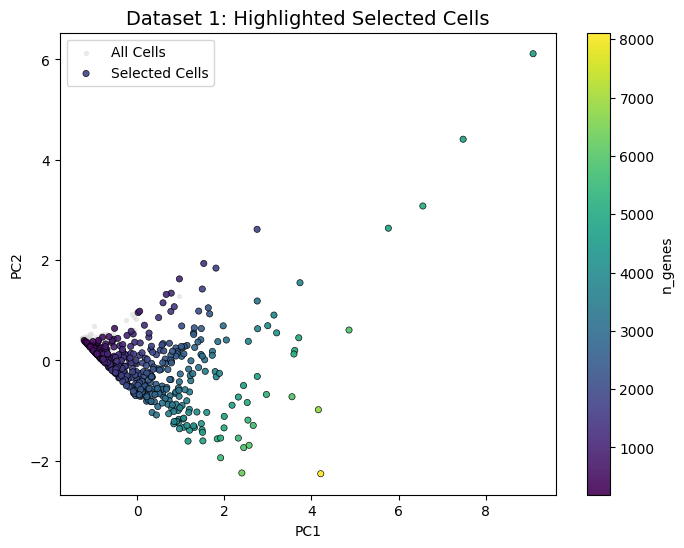

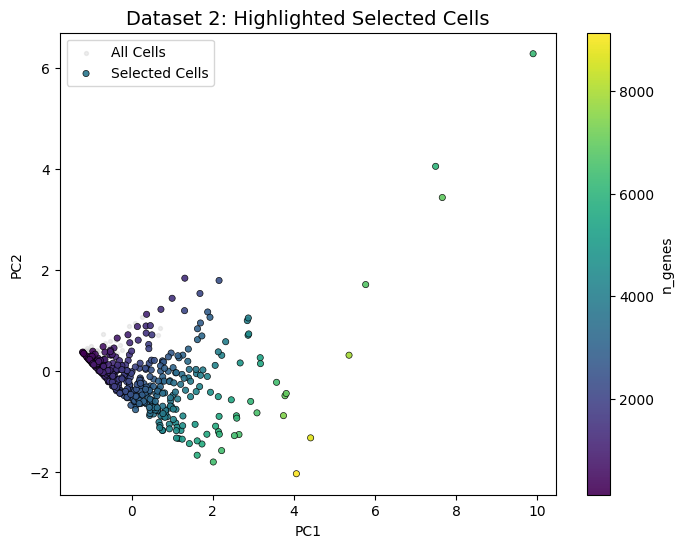

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================
# PCA Highlighted Plot Function
# ===============================================
def plot_pca_highlight(pca_df, selected_cells, color_metric, title):
    plt.figure(figsize=(8, 6))
    
    # Plot all cells in gray
    plt.scatter(
        pca_df['PC1'],
        pca_df['PC2'],
        color='lightgray',
        alpha=0.4,
        s=8,
        label='All Cells'
    )
    
    # Filter for selected cells
    highlight_df = pca_df.loc[pca_df['Cell_ID'].isin(selected_cells)].copy()
    
    # Plot highlighted cells with colormap
    scatter = plt.scatter(
        highlight_df['PC1'],
        highlight_df['PC2'],
        c=highlight_df[color_metric],
        cmap='viridis',
        s=20,
        alpha=0.9,
        edgecolor='black',
        linewidth=0.5,
        label='Selected Cells'
    )
    
    # Titles and colorbar
    plt.title(title, fontsize=14)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    cbar = plt.colorbar(scatter)
    cbar.set_label(color_metric)
    plt.legend()
    plt.show()

# ===============================================
# Example Usage for Both Datasets
# ===============================================
# color_metric can be 'n_counts' or 'n_genes' or any metric in pca_resultsX
color_metric = 'n_genes'

plot_pca_highlight(
    pca_results1,
    selected_cells=selected_cells_df1,
    color_metric=color_metric,
    title="Dataset 1: Highlighted Selected Cells"
)

plot_pca_highlight(
    pca_results2,
    selected_cells=selected_cells_df2,
    color_metric=color_metric,
    title="Dataset 2: Highlighted Selected Cells"
)


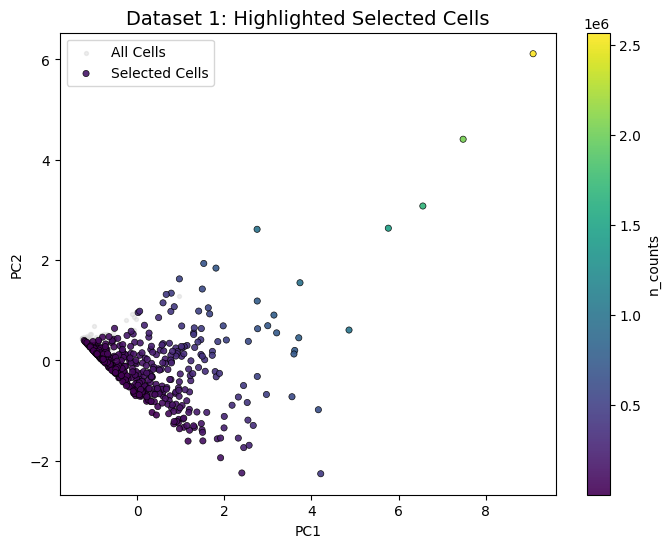

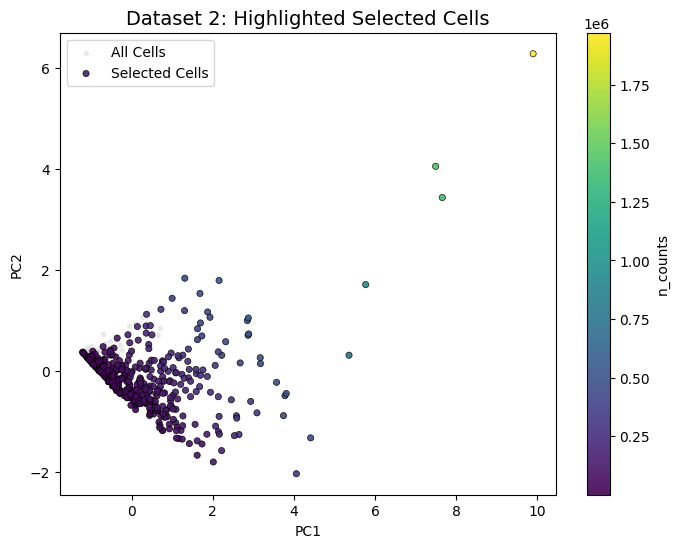

In [31]:
color_metric = 'n_counts'

plot_pca_highlight(
    pca_results1,
    selected_cells=selected_cells_df1,
    color_metric=color_metric,
    title="Dataset 1: Highlighted Selected Cells"
)

plot_pca_highlight(
    pca_results2,
    selected_cells=selected_cells_df2,
    color_metric=color_metric,
    title="Dataset 2: Highlighted Selected Cells"
)

In [32]:
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)

In [33]:
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)

In [34]:
sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata1, svd_solver='arpack')

In [35]:
sc.pp.scale(adata2, max_value=10)
sc.tl.pca(adata2, svd_solver='arpack')

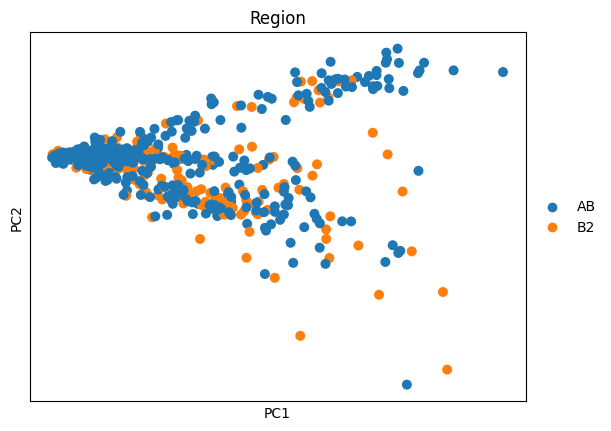

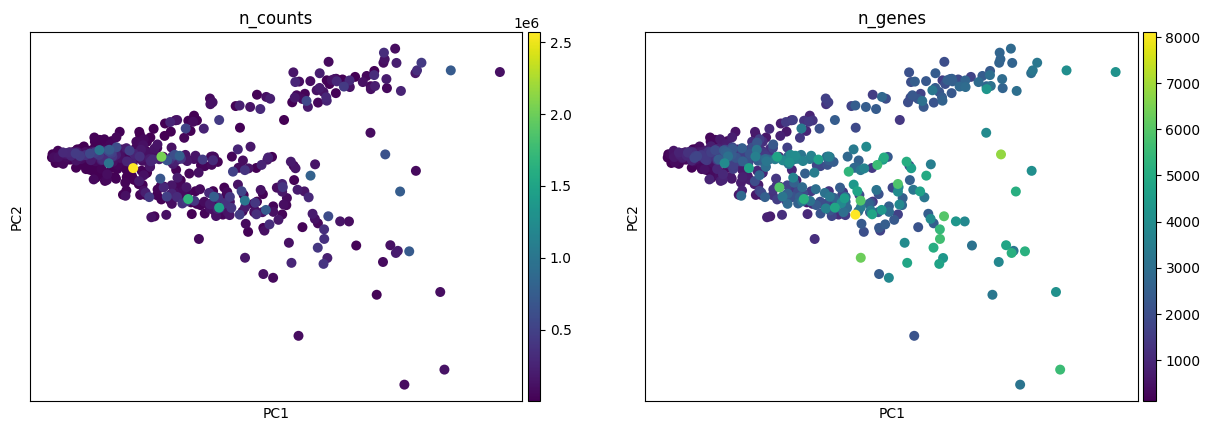

In [36]:
sc.pl.pca(adata1, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata1, color=['n_counts', 'n_genes'])

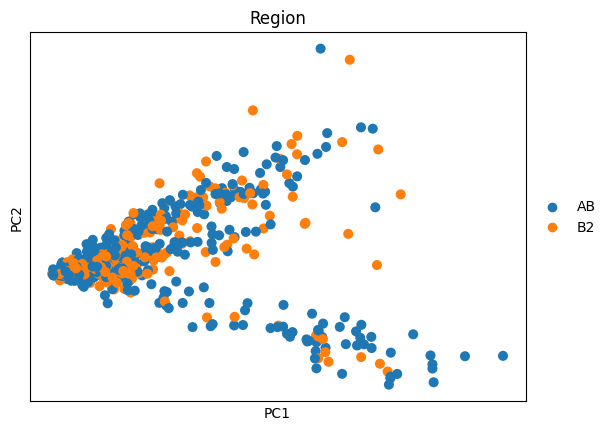

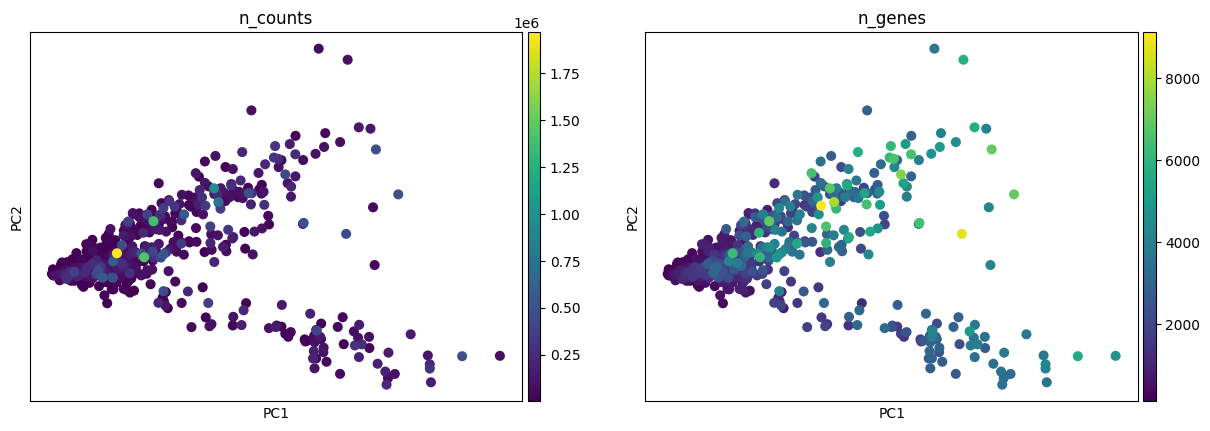

In [37]:
sc.pl.pca(adata2, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata2, color=['n_counts', 'n_genes'])

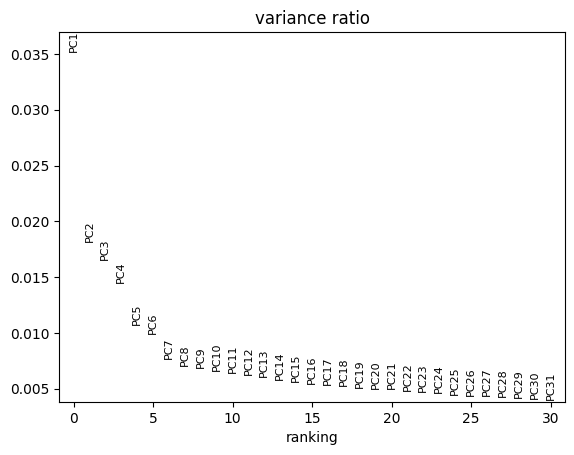

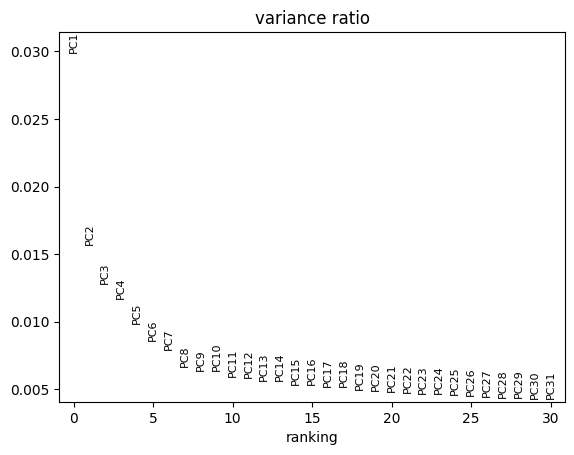

In [38]:
sc.pl.pca_variance_ratio(adata1, log=False)
sc.pl.pca_variance_ratio(adata2, log=False)


/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



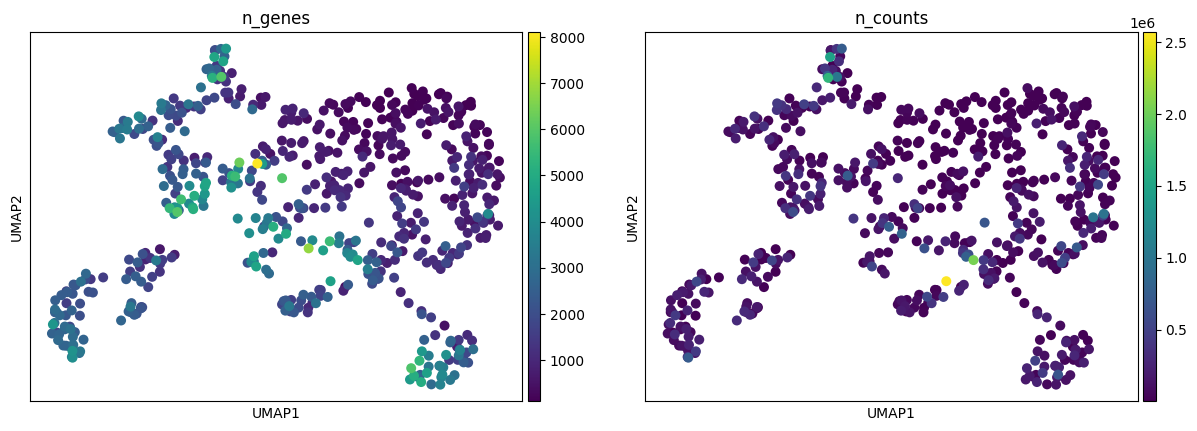

In [39]:
sc.pp.neighbors(adata1, n_neighbors=25, n_pcs=7)
sc.tl.umap(adata1)
# visualize umap based on n_genes and n_counts
sc.pl.umap(adata1, color=['n_genes', 'n_counts'])
# visualize umap based on sample metadata

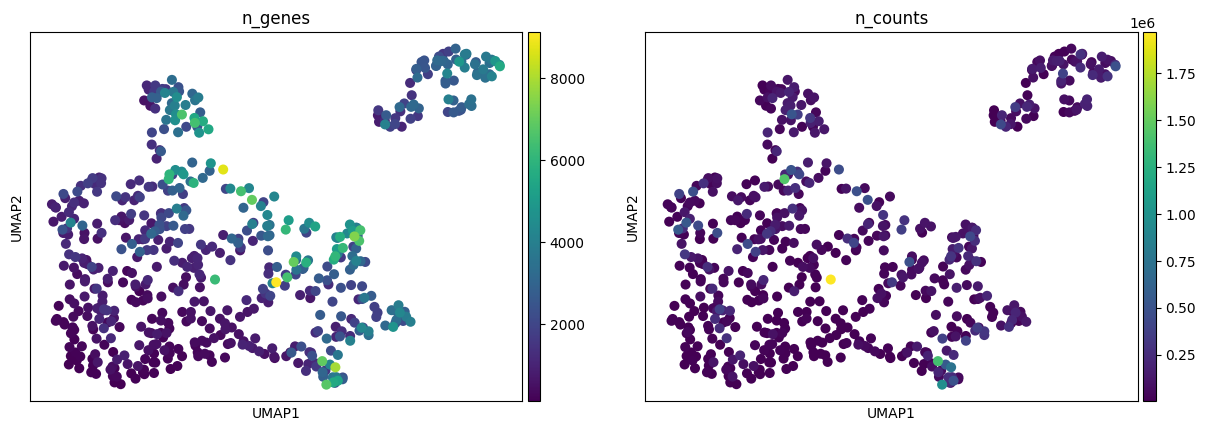

In [40]:
sc.pp.neighbors(adata2, n_neighbors=25, n_pcs=7)
sc.tl.umap(adata2)
# visualize umap based on n_genes and n_counts
sc.pl.umap(adata2, color=['n_genes', 'n_counts'])
# visualize umap based on sample metadata

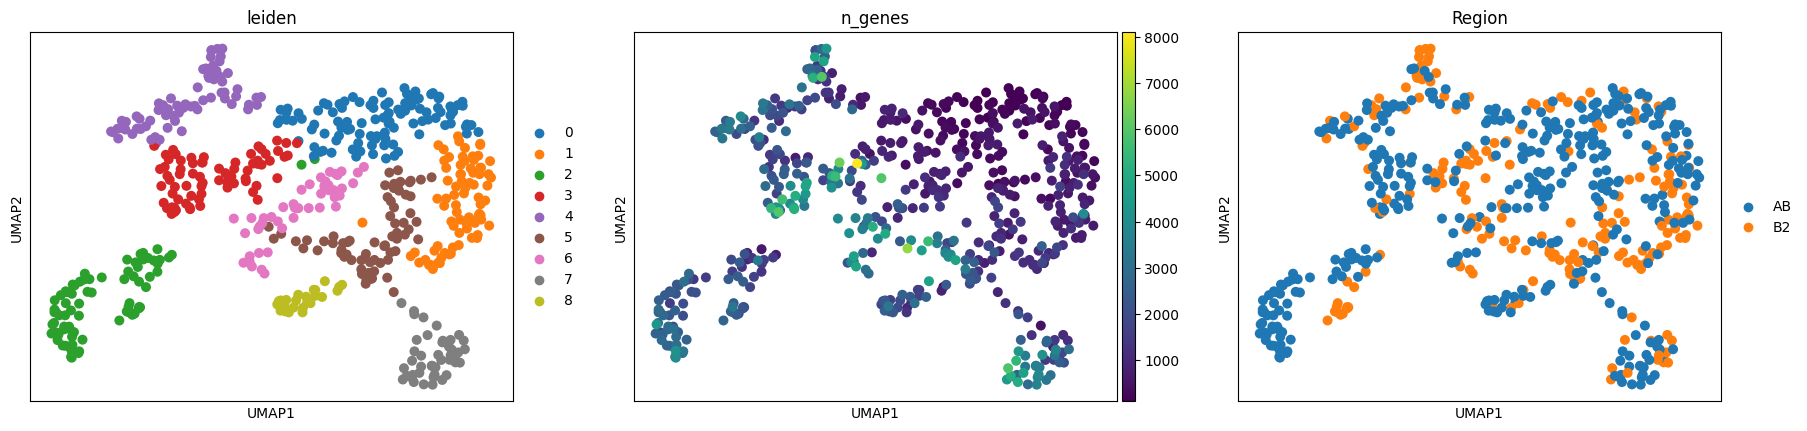

In [41]:
sc.tl.leiden(adata1, resolution=0.5)
sc.pl.umap(adata1, color=['leiden', 'n_genes', 'Region'])


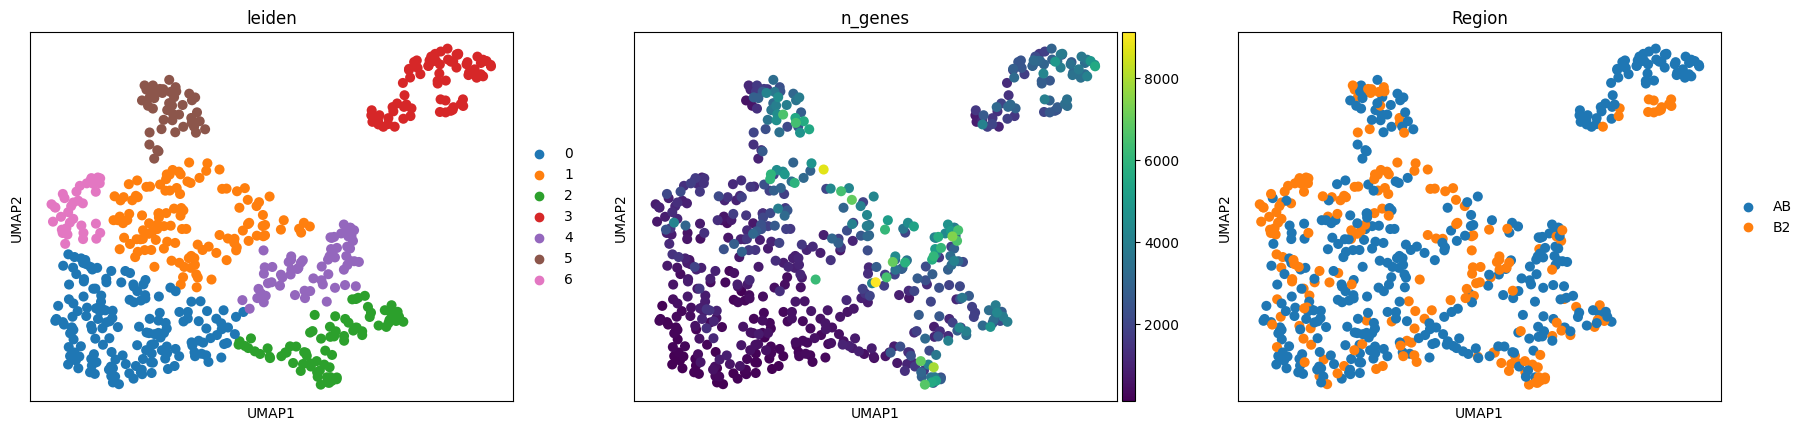

In [42]:
sc.tl.leiden(adata2, resolution=0.5)
sc.pl.umap(adata2, color=['leiden', 'n_genes', 'Region'])

In [43]:
sc.tl.rank_genes_groups(adata1, 'leiden', method='wilcoxon')
sc.tl.rank_genes_groups(adata2, 'leiden', method='wilcoxon')



/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/home/pissmaster/Desktop/comparison1_2/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

invalid value encountered in log2

/hom